In [1]:
# adp 18회 - 고객등급(1:최고~5:최하) 예측
#  (sales data - id / grade / days / count / amount )
# EDA, 결측치 처리, 시각화
# 3개의 파생변수 생성 및 이유
# train / test set 7:3 비율로 분할하여 SOM 으로 클러스터링하고
# 고객등급 예측 + confusion matrix 생성
# 랜덤포레스트, 다층신경망 포함하여 4가지 방법으로 예측하고 
# 예측결과로 각 모델별 f1 score 제시 + ROC커브 생성

In [5]:
### 적합한 데이터를 찾지 못하여 
### https://www.kaggle.com/regivm/retailtransactiondata 가공하여 사용

In [6]:
import pandas as pd

a = pd.read_csv('data/Retail_Data_Response.csv')
b = pd.read_csv('data/Retail_Data_Transactions.csv')


In [7]:
a.info()  # 고객별 캠페인 반응 여부 - 고객수 6884명 으로 추정

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6884 entries, 0 to 6883
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   customer_id  6884 non-null   object
 1   response     6884 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 107.7+ KB


In [9]:
a.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [26]:
b.info()  # 거래일자 및 거래금액  125천개 데이터 
# => 고객별 주문이 개별 행으로 입력되어있음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  125000 non-null  object
 1   trans_date   125000 non-null  object
 2   tran_amount  125000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


In [27]:
b.tail()

,customer_id,trans_date,tran_amount
124995,CS8433,26-Jun-11,64
124996,CS7232,19-Aug-14,38
124997,CS8731,28-Nov-14,42
124998,CS8133,14-Dec-13,13
124999,CS7996,13-Dec-14,36


In [37]:
### 개별 행으로 입력되어있는 주문정보를 고객별 주문으로 재분류

#bb = b.groupby(['customer_id','trans_date']).sum().groupby(level=0).cumsum()

### 고객별 주문량 합산
bb = b.groupby(['customer_id']).sum()
bb = bb.reset_index()
bb.columns = ['customer_id','amount_sum']
bb.head()

,customer_id,amount_sum
0,CS1112,1012
1,CS1113,1490
2,CS1114,1432
3,CS1115,1659
4,CS1116,857


In [39]:
### 고객별 가장 많이 구매한 날짜와 구매량
bbbbbbb = b.groupby(['customer_id']).max()
bbbbbbb

,trans_date,tran_amount
customer_id,,
CS1112,29-Apr-14,105
CS1113,30-Mar-12,98
CS1114,31-Dec-14,105
CS1115,27-Jun-13,104
CS1116,30-May-14,105
...,...,...
CS8996,29-Sep-12,79
CS8997,31-May-12,75
CS8998,27-Jul-12,79


In [35]:
### 고객별 총 구매횟수
bbb = b.groupby(['customer_id']).size()
bbb_df = pd.DataFrame(bbb)
bbb_df = bbb_df.reset_index()
bbb_df.columns = ['customer_id','trans_count']
bbb_df

,customer_id,trans_count
0,CS1112,15
1,CS1113,20
2,CS1114,19
3,CS1115,22
4,CS1116,13
...,...,...
6884,CS8996,13
6885,CS8997,14
6886,CS8998,13
6887,CS8999,12


In [32]:
### 고객별 구매량 평균 
bbbb = b.groupby(['customer_id']).mean()
bbbb = bbbb.reset_index()
bbbb.columns = ['customer_id','mean_tran_amount']
bbbb

,customer_id,mean_tran_amount
0,CS1112,67.466667
1,CS1113,74.500000
2,CS1114,75.368421
3,CS1115,75.409091
4,CS1116,65.923077
...,...,...
6884,CS8996,44.769231
6885,CS8997,38.785714
6886,CS8998,48.000000
6887,CS8999,31.916667


In [77]:
### 고객별 구매량 합, 최대, 최소, 평균을 하나의 표로 정리하면
amount_total = b.groupby('customer_id')['tran_amount'].aggregate(['sum','max','min','mean']).reset_index()
amount_total

,customer_id,sum,max,min,mean
0,CS1112,1012,105,36,67.466667
1,CS1113,1490,98,36,74.500000
2,CS1114,1432,105,37,75.368421
3,CS1115,1659,104,41,75.409091
4,CS1116,857,105,40,65.923077
...,...,...,...,...,...
6884,CS8996,582,79,24,44.769231
6885,CS8997,543,75,21,38.785714
6886,CS8998,624,79,13,48.000000
6887,CS8999,383,64,18,31.916667


In [92]:
### 구매기간 days 산출
### 날짜정보를 str -> datetime 으로 변경  pd.to_datetime()
### 가장 최근날짜와 가장 오래된 날짜의 간격 산출 (days)
import datetime

b_date = b.copy()
b_date['trans_date'] = pd.to_datetime(b['trans_date'])
b_date.info()
#29-Apr-14

b_date.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  125000 non-null  object        
 1   trans_date   125000 non-null  datetime64[ns]
 2   tran_amount  125000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.9+ MB


,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [93]:
### 구매기간 확인

diff_date = b_date.groupby(['customer_id'])['trans_date'].aggregate(['max','min']).reset_index()
diff_date['days'] = diff_date['max'] - diff_date['min']
diff_date.head()


,customer_id,max,min,days
0,CS1112,2015-01-14,2011-06-15,1309 days
1,CS1113,2015-02-09,2011-05-27,1354 days
2,CS1114,2015-02-12,2011-07-14,1309 days
3,CS1115,2015-03-05,2011-08-10,1303 days
4,CS1116,2014-08-25,2011-06-27,1155 days


In [94]:
diff_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6889 entries, 0 to 6888
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   customer_id  6889 non-null   object         
 1   max          6889 non-null   datetime64[ns] 
 2   min          6889 non-null   datetime64[ns] 
 3   days         6889 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), object(1), timedelta64[ns](1)
memory usage: 215.4+ KB


In [96]:
# 현재 기준 최종 구매 경과일수 (recency_days)
from datetime import datetime

diff_date['recency_days'] = datetime.today() - diff_date['max']
diff_date.head()

,customer_id,max,min,days,recency_days
0,CS1112,2015-01-14,2011-06-15,1309 days,2621 days 09:10:37.209655
1,CS1113,2015-02-09,2011-05-27,1354 days,2595 days 09:10:37.209655
2,CS1114,2015-02-12,2011-07-14,1309 days,2592 days 09:10:37.209655
3,CS1115,2015-03-05,2011-08-10,1303 days,2571 days 09:10:37.209655
4,CS1116,2014-08-25,2011-06-27,1155 days,2763 days 09:10:37.209655


In [97]:
### timedelta64 형식을 int 형태로 변환

import numpy as np
diff_date['days_int'] = (diff_date['days'] / np.timedelta64(1,'D')).astype(int)
diff_date['recency_days_int'] = (diff_date['recency_days'] / np.timedelta64(1,'D')).astype(int)
diff_date.head()

,customer_id,max,min,days,recency_days,days_int,recency_days_int
0,CS1112,2015-01-14,2011-06-15,1309 days,2621 days 09:10:37.209655,1309,2621
1,CS1113,2015-02-09,2011-05-27,1354 days,2595 days 09:10:37.209655,1354,2595
2,CS1114,2015-02-12,2011-07-14,1309 days,2592 days 09:10:37.209655,1309,2592
3,CS1115,2015-03-05,2011-08-10,1303 days,2571 days 09:10:37.209655,1303,2571
4,CS1116,2014-08-25,2011-06-27,1155 days,2763 days 09:10:37.209655,1155,2763


In [102]:
### 필요정보만 추출 + 병합
### 고객별 구매량 + 구매횟수(frequency) + 구매기간(duration)

b_total = pd.merge(amount_total, bbb_df, how='inner', on='customer_id')
b_total['days'] = diff_date['days_int']
b_total['recency_days'] = diff_date['recency_days_int']
b_total.columns = ['customer_id','sum_amount','max_amount','min_amount','mean_amount','frequency','duration(days)','recency(days)']
b_total.tail()

,customer_id,sum_amount,max_amount,min_amount,mean_amount,frequency,duration(days),recency(days)
6884,CS8996,582,79,24,44.769231,13,1120,2657
6885,CS8997,543,75,21,38.785714,14,1116,2821
6886,CS8998,624,79,13,48.000000,13,1293,2644
6887,CS8999,383,64,18,31.916667,12,1073,2817
6888,CS9000,533,77,16,41.000000,13,1273,2576


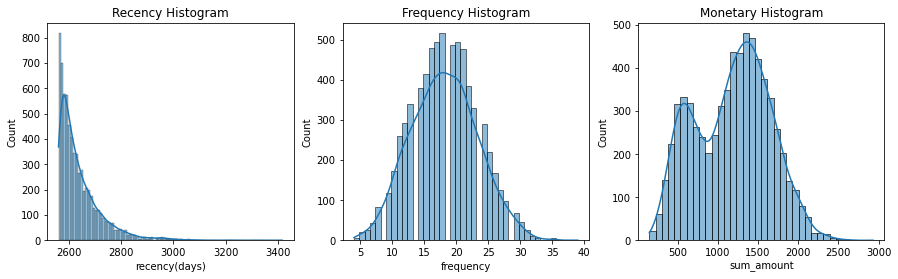

In [104]:
### 시각화 
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize=(15,4))

sns.histplot(b_total['recency(days)'], kde=True, ax=axs[0])
axs[0].set_title('Recency Histogram')

sns.histplot(b_total['frequency'], kde=True, ax=axs[1])
axs[1].set_title('Frequency Histogram')

sns.histplot(b_total['sum_amount'], kde=True, ax=axs[2])
axs[2].set_title('Monetary Histogram')

plt.show()

In [112]:
### RFM 으로 구분한 고객등급

### R / F / M 각각 20% 기준으로 5개 랭크로 구분
### (https://velog.io/@data_shirouto/RFM-%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%BD%94%EB%93%9C)
### (1: 제일 높음 ~ 5: 제일 낮음) 으로 변경 (rank 초기값 = 5로 설정)

df = b_total.copy()

colname = 'recency(days)'
p = 0.8
rank= 5
cluster = 'Rcluster' 
col = df[colname]
df.loc[df[ col >= col.quantile(q=p) ].index,cluster] = rank
df.loc[df[ (col.quantile(q=p) > col) & (col >= col.quantile(q=p-0.2)) ].index,cluster] = rank - 1
df.loc[df[ (col.quantile(q=p-0.2) > col) & (col >= col.quantile(q=p-0.4)) ].index,cluster] = rank - 2
df.loc[df[ (col.quantile(q=p-0.4) > col) & (col >= col.quantile(q=p-0.6)) ].index,cluster] = rank - 3
df.loc[df[ (col.quantile(q=p-0.6) > col) & (col >= col.quantile(q=p-0.8)) ].index,cluster] = rank - 4

colname = 'frequency'
p = 0.2
rank= 5
cluster = 'Fcluster' 
col = df[colname]
df.loc[df[ col <= col.quantile(q=p) ].index,cluster] = rank
df.loc[df[ (col.quantile(q=p) < col) & (col <= col.quantile(q=p+0.2)) ].index,cluster] = rank - 1
df.loc[df[ (col.quantile(q=p+0.2) < col) & (col <= col.quantile(q=p+0.4)) ].index,cluster] = rank - 2
df.loc[df[ (col.quantile(q=p+0.4) < col) & (col <= col.quantile(q=p+0.6)) ].index,cluster] = rank - 3
df.loc[df[ (col.quantile(q=p+0.6) < col) & (col <= col.quantile(q=p+0.8)) ].index,cluster] = rank - 4

colname = 'sum_amount'
p = 0.2
rank= 5
cluster = 'Mcluster' 
col = df[colname]
df.loc[df[ col <= col.quantile(q=p) ].index,cluster] = rank
df.loc[df[ (col.quantile(q=p) < col) & (col <= col.quantile(q=p+0.2)) ].index,cluster] = rank - 1
df.loc[df[ (col.quantile(q=p+0.2) < col) & (col <= col.quantile(q=p+0.4)) ].index,cluster] = rank - 2
df.loc[df[ (col.quantile(q=p+0.4) < col) & (col <= col.quantile(q=p+0.6)) ].index,cluster] = rank - 3
df.loc[df[ (col.quantile(q=p+0.6) < col) & (col <= col.quantile(q=p+0.8)) ].index,cluster] = rank - 4


df[['Rcluster','Fcluster','Mcluster']] = df[['Rcluster','Fcluster','Mcluster']].applymap(lambda x: int(x))
df

,customer_id,sum_amount,max_amount,min_amount,mean_amount,frequency,duration(days),recency(days),Rcluster,Fcluster,Mcluster
0,CS1112,1012,105,36,67.466667,15,1309,2621,3,4,4
1,CS1113,1490,98,36,74.500000,20,1354,2595,2,2,2
2,CS1114,1432,105,37,75.368421,19,1309,2592,2,3,2
3,CS1115,1659,104,41,75.409091,22,1303,2571,1,2,1
4,CS1116,857,105,40,65.923077,13,1155,2763,5,5,4
...,...,...,...,...,...,...,...,...,...,...,...
6884,CS8996,582,79,24,44.769231,13,1120,2657,4,5,5
6885,CS8997,543,75,21,38.785714,14,1116,2821,5,5,5
6886,CS8998,624,79,13,48.000000,13,1293,2644,4,5,5
6887,CS8999,383,64,18,31.916667,12,1073,2817,5,5,5


In [114]:
### RFM 가중치 부여는 업종별 특성에 맞춰 설정하는 것이 좋음
### https://m.blog.naver.com/bestinall/221672243147

### 그러나, 본 데이터에는 업종 특성이 드러나지 않았고
### 고객등급 분류 예측을 위한 데이터셋 제작이 목적이므로 
### 임의로 가중치를 부여하여 고객등급을 부여함

df['score'] = 0.3*df['Rcluster'] + 0.3*df['Fcluster'] + 0.4*df['Mcluster'] ## 고객별 점수 계산
 

## 고객별 등급 부여 (1: 제일 높음 ~ 5: 제일 낮음)

colname = 'score'
p = 0.2
rank= 1
cluster = 'grade' 
col = df[colname]
df.loc[df[ col <= col.quantile(q=p) ].index,cluster] = rank
df.loc[df[ (col.quantile(q=p) < col) & (col <= col.quantile(q=p+0.2)) ].index,cluster] = rank + 1
df.loc[df[ (col.quantile(q=p+0.2) < col) & (col <= col.quantile(q=p+0.4)) ].index,cluster] = rank + 2
df.loc[df[ (col.quantile(q=p+0.4) < col) & (col <= col.quantile(q=p+0.6)) ].index,cluster] = rank + 3
df.loc[df[ (col.quantile(q=p+0.6) < col) & (col <= col.quantile(q=p+0.8)) ].index,cluster] = rank + 4

df[['grade']] = df[['grade']].applymap(lambda x: int(x))
df

,customer_id,sum_amount,max_amount,min_amount,mean_amount,frequency,duration(days),recency(days),Rcluster,Fcluster,Mcluster,score,grade
0,CS1112,1012,105,36,67.466667,15,1309,2621,3,4,4,3.7,4
1,CS1113,1490,98,36,74.500000,20,1354,2595,2,2,2,2.0,2
2,CS1114,1432,105,37,75.368421,19,1309,2592,2,3,2,2.3,2
3,CS1115,1659,104,41,75.409091,22,1303,2571,1,2,1,1.3,1
4,CS1116,857,105,40,65.923077,13,1155,2763,5,5,4,4.6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,CS8996,582,79,24,44.769231,13,1120,2657,4,5,5,4.7,5
6885,CS8997,543,75,21,38.785714,14,1116,2821,5,5,5,5.0,5
6886,CS8998,624,79,13,48.000000,13,1293,2644,4,5,5,4.7,5
6887,CS8999,383,64,18,31.916667,12,1073,2817,5,5,5,5.0,5


In [116]:
### 분석용 데이터 셋 완성
ddf = df.copy()
ddf = ddf.drop(['max_amount','min_amount','mean_amount','duration(days)','Rcluster','Fcluster','Mcluster','score'], axis=1)
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6889 entries, 0 to 6888
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_id    6889 non-null   object
 1   sum_amount     6889 non-null   int64 
 2   frequency      6889 non-null   int64 
 3   recency(days)  6889 non-null   int32 
 4   grade          6889 non-null   int64 
dtypes: int32(1), int64(3), object(1)
memory usage: 554.1+ KB


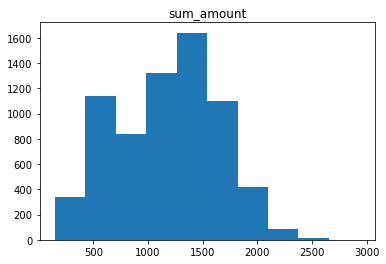

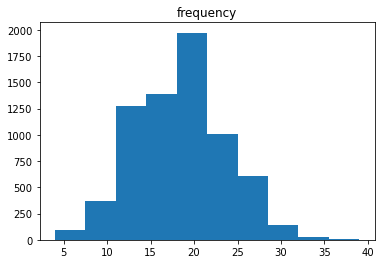

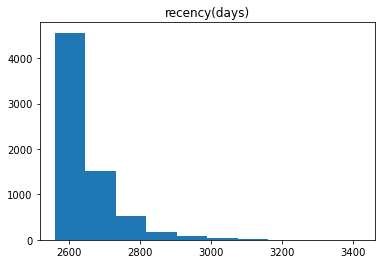

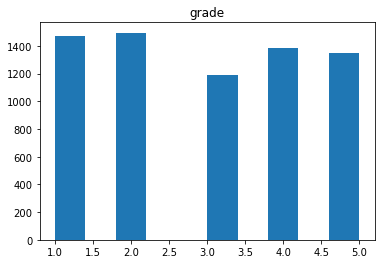

In [118]:
### EDA 및 시각화

for v in ddf.select_dtypes(include='int'):
    target = ddf[v]
    plt.hist(target)
    plt.title(v)
    plt.show()

In [121]:
d1 = ddf.groupby('grade')['sum_amount'].aggregate(['sum','max','min','mean']).reset_index()
d2 = ddf.groupby('grade')['frequency'].aggregate(['sum','max','min','mean']).reset_index()
d3 = ddf.groupby('grade')['recency(days)'].aggregate(['sum','max','min','mean']).reset_index()

# 등급별 
print('등급별 구매총량')
d1

등급별 구매총량


,grade,sum,max,min,mean
0,1,2578311,2933,1151,1750.380855
1,2,2137505,2513,736,1429.769231
2,3,1389852,1589,581,1167.942857
3,4,1196569,1405,164,865.198120
4,5,821752,1166,149,609.608309


In [122]:
print('등급별 구매빈도')
d2


등급별 구매빈도


,grade,sum,max,min,mean
0,1,36357,39,20,24.682281
1,2,30738,36,15,20.560535
2,3,21484,26,14,18.053782
3,4,20283,23,5,14.665944
4,5,16138,17,4,11.971810


In [123]:
print('등급별 recency(days)')
d3

등급별 recency(days)


,grade,sum,max,min,mean
0,1,3817925,2687,2560,2591.938221
1,2,3909644,2891,2560,2615.146488
2,3,3135502,2984,2560,2634.875630
3,4,3647031,3010,2560,2637.043384
4,5,3680566,3417,2599,2730.390208


In [127]:
### 파생변수 3개 생성 및 생성 이유
### -> 고객별 특성을 파악하기 위해 군집분석을 진행해야 하는데 
###    sum_amount / frequency / recency(days) 의 단위가 각각 다르므로
###    위의 3가지 변수를 scaling 한 파생변수를 생성해야 함


from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
             
X_features = ddf[['sum_amount','frequency','recency(days)']].values
X_features_scaled = sc.fit_transform(X_features)

X_features_scaled


array([[0.30998563, 0.31428571, 0.07117853],
       [0.48168103, 0.45714286, 0.04084014],
       [0.4608477 , 0.42857143, 0.03733956],
       ...,
       [0.17061782, 0.25714286, 0.09801634],
       [0.08405172, 0.22857143, 0.29988331],
       [0.13793103, 0.25714286, 0.01866978]])

In [134]:
X_features_sc = pd.DataFrame(X_features_scaled)
X_features_sc.columns = ['sum_amount_sc','freq_sc','recency_sc']

label = ddf['grade']

X_features_sc


,sum_amount_sc,freq_sc,recency_sc
0,0.309986,0.314286,0.071179
1,0.481681,0.457143,0.040840
2,0.460848,0.428571,0.037340
3,0.542385,0.514286,0.012835
4,0.254310,0.257143,0.236873
...,...,...,...
6884,0.155532,0.257143,0.113186
6885,0.141523,0.285714,0.304551
6886,0.170618,0.257143,0.098016
6887,0.084052,0.228571,0.299883


시작시간: 2022-03-19 11:01:12.338194 



C:\ProgramData\Anaconda3\lib\site-packages\minisom.py:513: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)



종료시간: 2022-03-19 11:03:00.206269 
총 소요시간: 0 days 00:01:47.868075


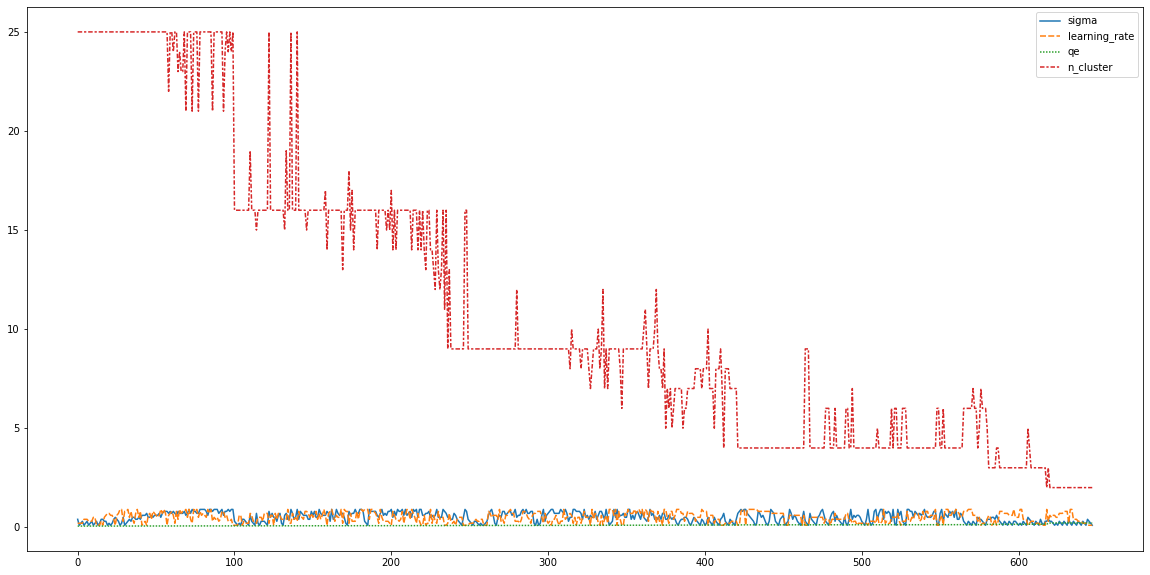

In [137]:
### SOM 으로 군집분석 (pip install minisom)
### https://studying-haeung.tistory.com/4

from minisom import MiniSom

s_time = pd.Timestamp.now()
print('시작시간:',s_time,'\n')

#원하는 파라미터 조합 리스트화
map_n= [n for n in range(2,6)]
para_sigma= [np.round(sigma*0.1,2) for sigma in range(1,10)]
para_learning_rate= [np.round(learning_rate*0.1,2) for learning_rate in range(1,10)]


data = X_features_sc

#결과 값을 담을 리스트 res 생성
res = []
#모든 조합에 대해 모델 생성 및 qe,te값 계산
for n in map_n:
    for sigma in para_sigma:
        for lr in para_learning_rate:
            
            try:
                #랜덤으로 초기값을 설정하는 경우
                estimator = MiniSom(n,n,3,sigma =sigma, learning_rate = lr, topology='hexagonal',random_seed=0)
                estimator.random_weights_init(data.values)
                estimator.train(data.values,1000,random_order=True)
                qe = estimator.quantization_error(data.values)
                #te = estimator.topographic_error(data.values)
                winner_coordinates = np.array([estimator.winner(x) for x in data.values]).T
                cluster_index = np.ravel_multi_index(winner_coordinates,(n,n))
                
                res.append([str(n)+'x'+str(n),sigma,lr,'random_init',qe,len(np.unique(cluster_index))])

                #pca로 초기값을 설정하는 경우
                estimator = MiniSom(n,n,3,sigma =sigma, learning_rate = lr,topology='hexagonal', random_seed=0)
                estimator.pca_weights_init(data.values)
                estimator.train(data.values,1000,random_order=True)
                qe = estimator.quantization_error(data.values)
                #te = estimator.topographic_error(data.values)
                winner_coordinates = np.array([estimator.winner(x) for x in data.values]).T
                cluster_index = np.ravel_multi_index(winner_coordinates,(n,n))
                
                res.append([str(n)+'x'+str(n),sigma,lr,'pca_init',qe,len(np.unique(cluster_index))])
                
            except ValueError as e:
                print(e)
            
#결과 데이터프레임 생성 및 sorting 
df_res = pd.DataFrame(res,columns=['map_size','sigma','learning_rate','init_method','qe','n_cluster']) 
df_res.shape
df_res.sort_values(by=['qe'],ascending=True,inplace=True,ignore_index=True)
df_res.head(10)

#시각화를 위한 lineplot 생성
plt.figure(figsize=(20,10))
sns.lineplot(data = df_res)

e_time = pd.Timestamp.now()
print('\n종료시간:',e_time,'\n총 소요시간:',e_time-s_time)

In [138]:
## 모델 파라미터를 5개 클러스터 

som_b2 = MiniSom(3,3,3,sigma=0.3,learning_rate=0.2,topology='hexagonal',neighborhood_function='gaussian',activation_distance='euclidean', random_seed=0)
#초기값설정
som_b2.pca_weights_init(data.values)
som_b2.train(data.values,1000,random_order=True)

#평가
som_b2.quantization_error(data.values)
#som_b2.topographic_error(data.values)

0.15113144404013062

In [ ]:
### train / test set 7:3 비율로 분할하여 SOM 클러스터링 +예측+confusionmatrix

### -> .....confusionmatrix 라는건 실제값을 grade 5개로 한다는건가?
###    그러면 SOM 클러스터링 갯수도 5개여야하는건데
###    5개 클래스에 대해서 rf 같은걸로 분류 가능?
###    다항분류 아무리 많이 한들 3개 정도 아님?